In [1]:
import pandas as pd
import skimage.io
import skimage.color
import skimage.metrics
import skimage.util
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import io
import os
import math

%matplotlib inline
daily_data_volume_gb = {
    "Modis": 17.51,
    "GeoEye-1": 921.05,
}

print("Dane wejściowe (dzienny wolumen danych w GB):")
for sensor, volume in daily_data_volume_gb.items():
    print(f"- {sensor}: {volume} GB")

Dane wejściowe (dzienny wolumen danych w GB):
- Modis: 17.51 GB
- GeoEye-1: 921.05 GB


In [2]:
def simulate_volume_compression(sensor_data_gb):
    """Symuluje wolumen danych po kompresji."""

    results = []

    for sensor_name, original_volume_gb in sensor_data_gb.items():
        compressed_2_1 = original_volume_gb / 2
        compressed_5_1 = original_volume_gb / 5
        compressed_10_1 = original_volume_gb / 10
        compressed_20_1 = original_volume_gb / 20

        results.append({
            "Nazwa sensora": sensor_name,
            "Dane przed kompresją (GB)": original_volume_gb,
            "Dane po kompresji 2:1 (GB)": compressed_2_1,
            "Dane po kompresji 5:1 (GB)": compressed_5_1,
            "Dane po kompresji 10:1 (GB)": compressed_10_1,
            "Dane po kompresji 20:1 (GB)": compressed_20_1
        })

    df_results = pd.DataFrame(results)

    return df_results
compression_results_df = simulate_volume_compression(daily_data_volume_gb)

print("\nTabela wpływu kompresji na dzienny wolumen danych:")
print(compression_results_df)


Tabela wpływu kompresji na dzienny wolumen danych:
  Nazwa sensora  Dane przed kompresją (GB)  Dane po kompresji 2:1 (GB)  \
0         Modis                      17.51                       8.755   
1      GeoEye-1                     921.05                     460.525   

   Dane po kompresji 5:1 (GB)  Dane po kompresji 10:1 (GB)  \
0                       3.502                        1.751   
1                     184.210                       92.105   

   Dane po kompresji 20:1 (GB)  
0                       0.8755  
1                      46.0525  


Wczytano obraz: geoeye-1-vatican-city.jpg
Typ danych wczytanego obrazu: uint8
Wymiary wczytanego obrazu: (3000, 3000, 3)
Obraz RGB, konwertuję do skali szarości.


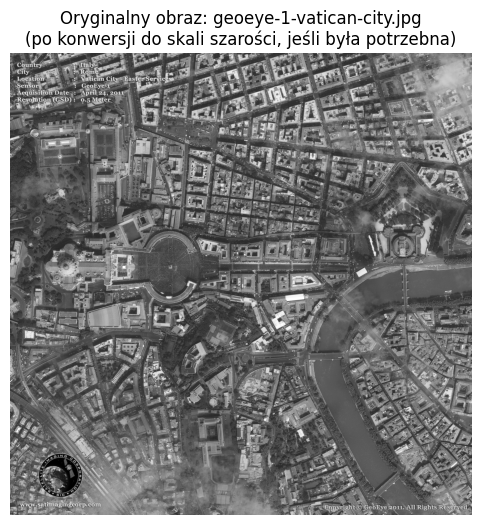

Typ danych finalnego obrazu (original_image): uint8
Wymiary finalnego obrazu: (3000, 3000)
Zakres wartości pikseli: 0 - 255


In [16]:

image_filename = "geoeye-1-vatican-city.jpg"

image_path = os.path.join(image_filename)

original_image = None

try:
    loaded_image = skimage.io.imread(image_path)

    if loaded_image is None:
        raise IOError(f"Nie udało się wczytać obrazu z: {image_path}")

    print(f"Wczytano obraz: {image_path}")
    print(f"Typ danych wczytanego obrazu: {loaded_image.dtype}")
    print(f"Wymiary wczytanego obrazu: {loaded_image.shape}")

    if loaded_image.ndim == 3:
        if loaded_image.shape[2] == 4: # RGBA
            print("Obraz RGBA, konwertuję do RGB, a następnie do skali szarości.")
            # Konwersja RGBA do RGB (ignorowanie kanału alfa)
            loaded_image_rgb = skimage.color.rgba2rgb(loaded_image)
             # Konwersja RGB do skali szarości (wynik jako float64 w zakresie [0,1])
            original_image_gray = skimage.color.rgb2gray(loaded_image_rgb)
        elif loaded_image.shape[2] == 3: # RGB
            print("Obraz RGB, konwertuję do skali szarości.")
            # Konwersja RGB do skali szarości (wynik jako float64 w zakresie [0,1])
            original_image_gray = skimage.color.rgb2gray(loaded_image)
        else:
            print(f"Obraz ma {loaded_image.shape[2]} kanałów. Używam pierwszego kanału jako skali szarości.")
            original_image_gray = loaded_image[..., 0] # Weź pierwszy kanał
    elif loaded_image.ndim == 2:
        print("Obraz jest już w skali szarości.")
        original_image_gray = loaded_image
    else:
        raise ValueError(f"Nieobsługiwana liczba wymiarów obrazu: {loaded_image.ndim}. Oczekiwano 2 (skala szarości) lub 3 (kolor).")


    original_image = skimage.util.img_as_ubyte(original_image_gray)

    plt.figure(figsize=(6, 6))
    plt.imshow(original_image, cmap='gray')
    plt.title(f"Oryginalny obraz: {image_filename}\n(po konwersji do skali szarości, jeśli była potrzebna)")
    plt.axis('off')
    plt.show()

    print(f"Typ danych finalnego obrazu (original_image): {original_image.dtype}")
    print(f"Wymiary finalnego obrazu: {original_image.shape}")
    print(f"Zakres wartości pikseli: {original_image.min()} - {original_image.max()}")

except FileNotFoundError:
    print(f"BŁĄD: Nie znaleziono pliku obrazu: {image_path}")
    print(f"Upewnij się, że folder '{data_folder}' istnieje w tym samym miejscu co notatnik,")
    print(f"oraz że plik '{image_filename}' znajduje się wewnątrz folderu '{data_folder}'.")
    print("Popraw zmienną 'image_filename' i/lub umieść plik w odpowiednim miejscu.")
except Exception as e:
    print(f"Wystąpił nieoczekiwany błąd podczas wczytywania lub przetwarzania obrazu: {e}")
    print("Sprawdź, czy plik obrazu nie jest uszkodzony i czy jest to obsługiwany format (np. PNG, JPG, TIF).")


In [15]:
import os
import io
import numpy as np
from PIL import Image
import skimage.util
import skimage.metrics

def compress_jpeg_in_memory(image_array, quality_level, output_path=None):
    """Kompresuje obraz do formatu JPEG w pamięci i zwraca skompresowany obraz oraz jego rozmiar."""
    # Konwersja na obiekt Pillow
    pil_image = Image.fromarray(image_array)

    # Obsługa obrazów RGBA (z kanałem alfa)
    if pil_image.mode == 'RGBA':
        pil_image = pil_image.convert('RGB')

    img_buffer = io.BytesIO()
    pil_image.save(img_buffer, format="JPEG", quality=quality_level, optimize=True)
    file_size_bytes = img_buffer.tell()

    # Zapis na dysku jeśli podano ścieżkę
    if output_path is not None:
        with open(output_path, 'wb') as f:
            f.write(img_buffer.getvalue())

    file_size_kb = file_size_bytes / 1024.0
    img_buffer.seek(0)

    # Dekodowanie z powrotem do tablicy numpy
    decompressed_pil_image = Image.open(img_buffer)
    decompressed_image_array = np.array(decompressed_pil_image)

    return decompressed_image_array, file_size_kb

# Główna część skryptu
if 'original_image' in globals() and original_image is not None:
    # Konwersja do float [0, 1] dla obliczeń SSIM i różnic
    original_image_float = skimage.util.img_as_float(original_image)

    # Przebudowujemy compressed_results od zera
    new_compressed_results = []

    jpeg_quality_levels = [95, 75, 50, 25, 10, 5]

    # Utwórz folder na wyniki
    output_dir = "compressed_images"
    os.makedirs(output_dir, exist_ok=True)

    print("\nRozpoczynam kompresję dla obrazu kolorowego...")
    print(f"Typ obrazu: {original_image.dtype}, Wymiary: {original_image.shape}")

    for quality in jpeg_quality_levels:
        # Generuj unikalną nazwę pliku
        output_path = os.path.join(output_dir, f"compressed_q{quality}.jpg")

        # Kompresja i zapis
        compressed_img_uint8, size_kb = compress_jpeg_in_memory(
            original_image,
            quality,
            output_path=output_path
        )

        # Konwersja do float dla obliczeń
        compressed_img_float = skimage.util.img_as_float(compressed_img_uint8)

        # Obliczanie PSNR dla obrazów kolorowych
        psnr_value = skimage.metrics.peak_signal_noise_ratio(
            original_image,
            compressed_img_uint8,
            data_range=255
        )

        # Obliczanie SSIM z uwzględnieniem kanałów kolorów
        min_dimension = min(original_image.shape[:2])
        current_win_size = min(7, min_dimension if min_dimension % 2 != 0 else min_dimension - 1)

        if current_win_size < 3:
            print(f"Ostrzeżenie: Obraz jest za mały dla SSIM. Pomijam.")
            ssim_value = np.nan
        else:
            ssim_value = skimage.metrics.structural_similarity(
                original_image_float,
                compressed_img_float,
                data_range=1.0,
                win_size=current_win_size,
                channel_axis=2 if original_image.ndim == 3 else None  # Kluczowa zmiana dla koloru!
            )

        # Obliczanie różnicy między obrazami (dla każdego kanału osobno)
        diff_map_float = np.abs(original_image_float - compressed_img_float)

        # Zapisujemy wyniki
        new_compressed_results.append({
            "quality": quality,
            "image": compressed_img_uint8,
            "size_kb": size_kb,
            "psnr": psnr_value,
            "ssim": ssim_value,
            "diff_map": diff_map_float,
            "file_path": output_path
        })

        print(f"Jakość: {quality} | "
              f"Rozmiar: {size_kb:.2f} KB | "
              f"PSNR: {psnr_value:.2f} dB | "
              f"SSIM: {ssim_value:.3f} | "
              f"Zapisano: {output_path}")

    # Aktualizujemy wyniki
    compressed_results = new_compressed_results

else:
    print("\nBłąd: Obraz wejściowy nie został załadowany.")
    compressed_results = []

ValueError: Cannot convert from <U25 to float64.

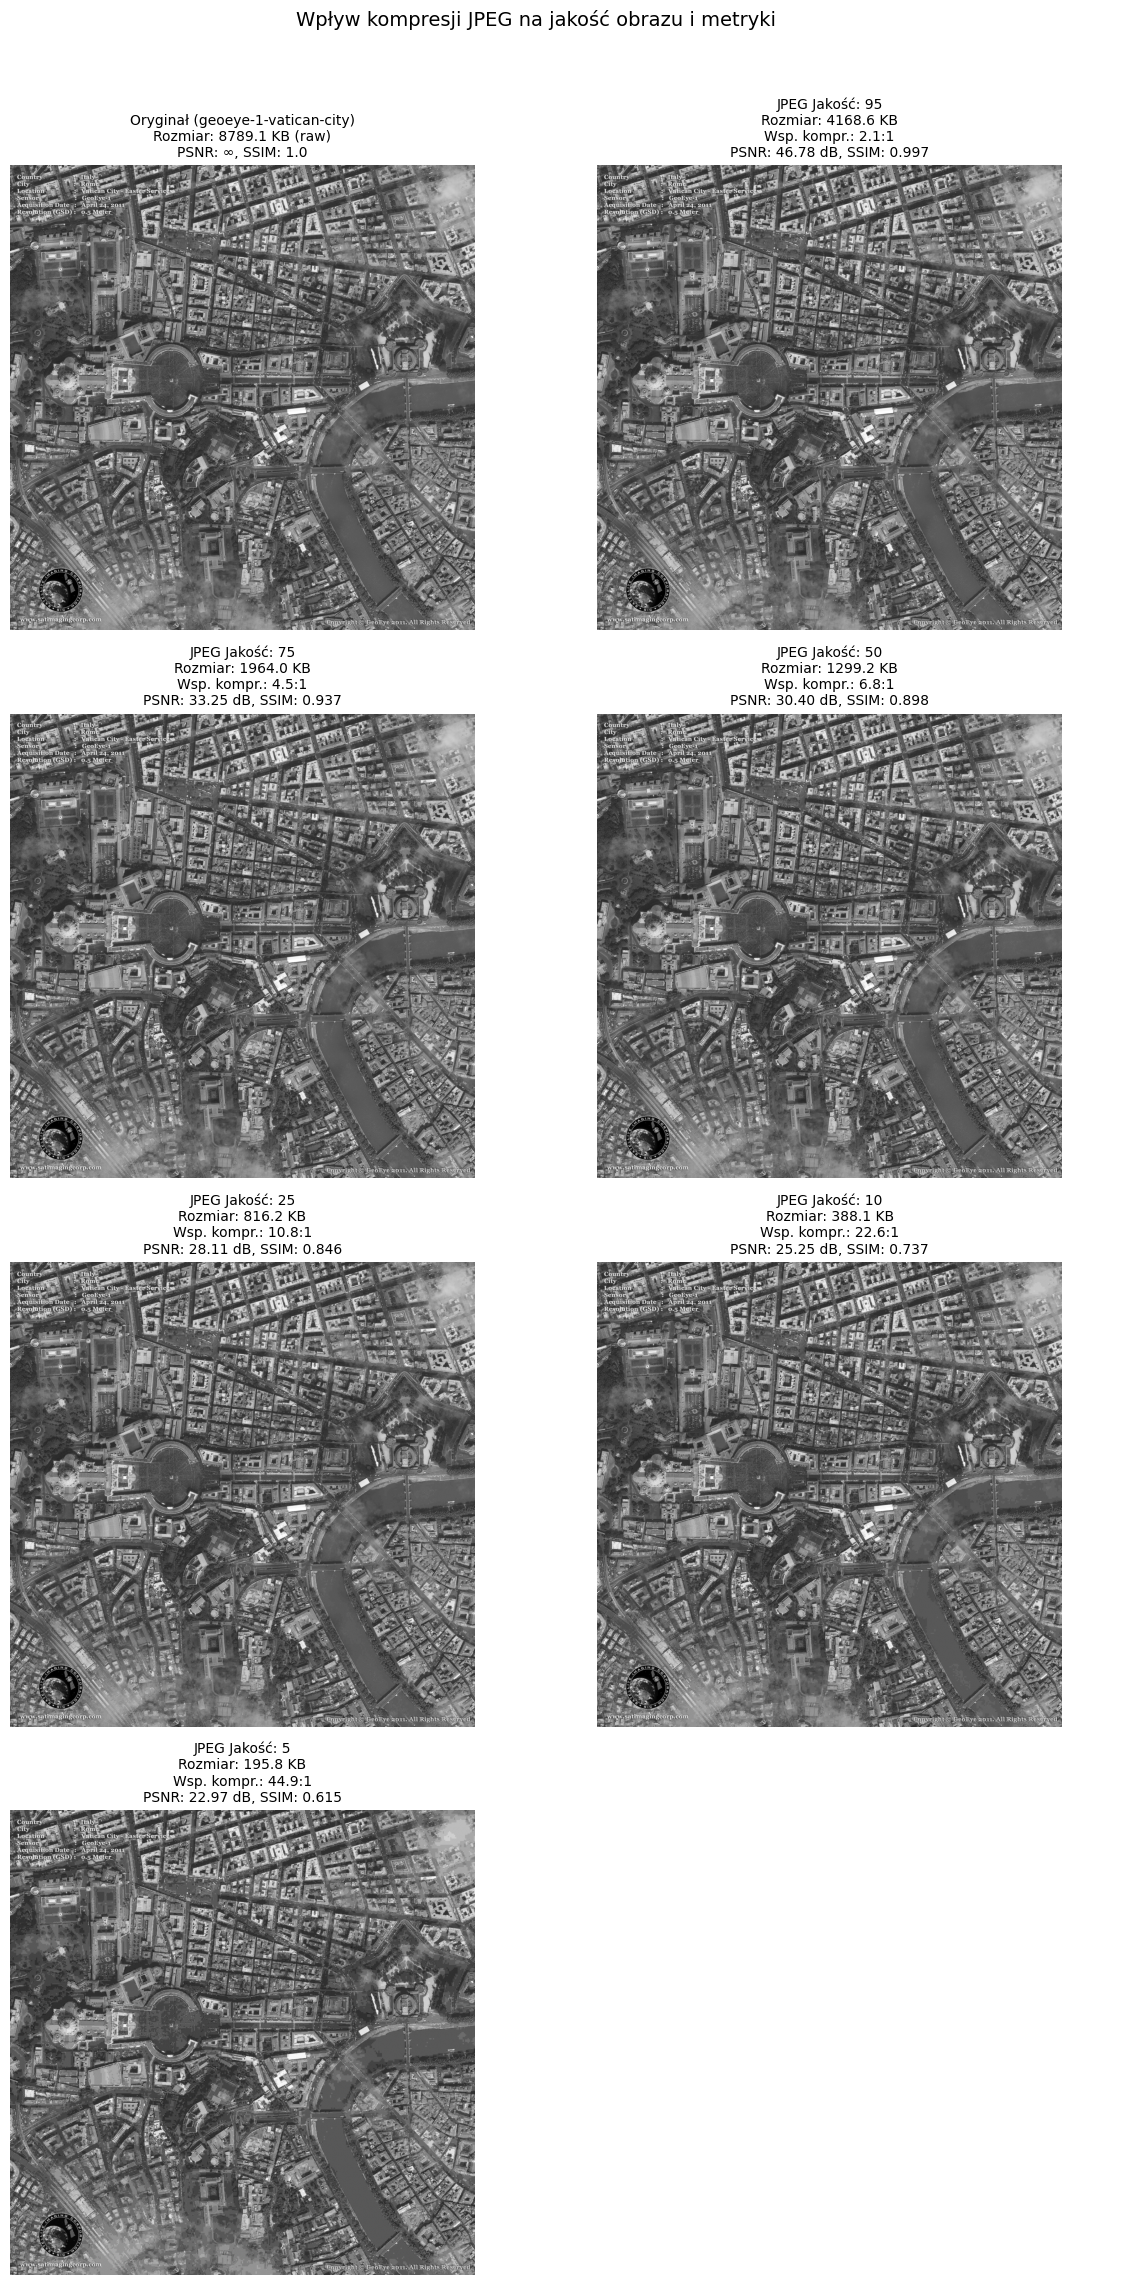

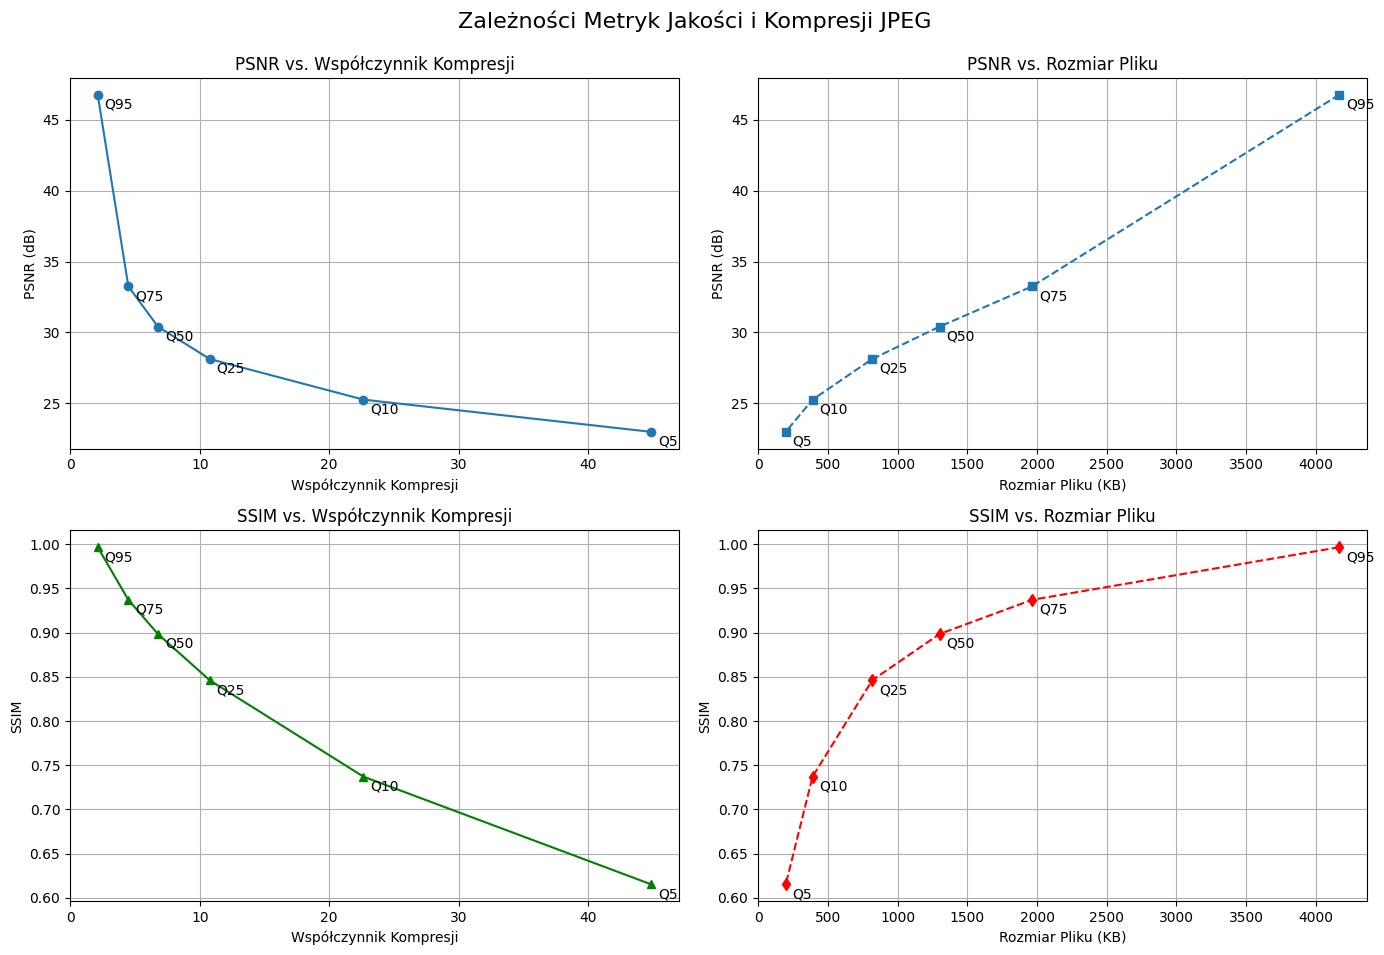

In [9]:
if 'original_image' in globals() and original_image is not None and \
   'compressed_results' in globals() and compressed_results:

    original_size_bytes = original_image.nbytes
    original_size_kb = original_size_bytes / 1024.0

    # --- Przygotowanie danych do wyświetlenia (tylko obrazy i ich metryki) ---
    display_items = []

    # Oryginalny obraz
    display_items.append({
        "image_to_show": original_image, # uint8
        "title_lines": [
            f"Oryginał ({image_filename.split('.')[0] if 'image_filename' in globals() else 'Obraz'})",
            f"Rozmiar: {original_size_kb:.1f} KB (raw)",
            "PSNR: ∞, SSIM: 1.0"
        ]
    })

    # Skompresowane obrazy
    for result in compressed_results:
        compression_ratio = original_size_kb / result["size_kb"] if result["size_kb"] > 0 else float('inf')
        display_items.append({
            "image_to_show": result["image"], # uint8
            "title_lines": [
                f"JPEG Jakość: {result['quality']}",
                f"Rozmiar: {result['size_kb']:.1f} KB",
                f"Wsp. kompr.: {compression_ratio:.1f}:1",
                f"PSNR: {result['psnr']:.2f} dB, SSIM: {result['ssim']:.3f}"
            ]
        })

    num_display_items = len(display_items)
    ncols_vis = 2 # Dwa obrazy w rzędzie
    nrows_vis = math.ceil(num_display_items / ncols_vis)

    fig_vis_width_per_subplot = 6
    fig_vis_height_per_row = 6 # Można dostosować wysokość

    fig_vis, axes_vis = plt.subplots(nrows_vis, ncols_vis,
                                     figsize=(fig_vis_width_per_subplot * ncols_vis, fig_vis_height_per_row * nrows_vis),
                                     squeeze=False) # squeeze=False jest dobre dla ogólności

    axes_flat = axes_vis.flatten() # Spłaszczenie dla łatwiejszej iteracji

    for i, item_data in enumerate(display_items):
        ax = axes_flat[i]
        ax.imshow(item_data["image_to_show"], cmap='gray', vmin=0, vmax=255)
        ax.set_title("\n".join(item_data["title_lines"]), fontsize=10)
        ax.axis('off')

    # Ukryj nieużywane osie, jeśli liczba obrazów nie wypełnia idealnie siatki
    for j in range(num_display_items, nrows_vis * ncols_vis):
        axes_flat[j].axis('off') # Prostsze niż fig.delaxes

    fig_vis.tight_layout(rect=[0, 0.03, 1, 0.95]) # Dostosuj rect dla suptitle
    fig_vis.suptitle("Wpływ kompresji JPEG na jakość obrazu i metryki", fontsize=14, y=0.98) # Dostosuj y
    plt.show()

    # --- Wykresy PSNR/SSIM vs. Współczynnik Kompresji / Rozmiar Pliku (bez zmian) ---
    # Ten kod pozostaje taki sam jak w poprzedniej odpowiedzi, gdzie generował wykresy 2x2.
    # Upewnij się, że masz dane: qualities, psnr_values, ssim_values,
    # compression_ratios_all, file_sizes_all, compression_ratios_for_ssim,
    # file_sizes_for_ssim, qualities_for_ssim zdefiniowane przed tą sekcją.

    # (Poniżej jest kopia sekcji wykresów punktowych dla kompletności)
    qualities = [res['quality'] for res in compressed_results]
    psnr_values = [res['psnr'] for res in compressed_results]
    # Upewnij się, że ssim_values i odpowiednie listy dla osi X są poprawnie filtrowane, jeśli SSIM mogło nie zostać obliczone
    valid_indices_for_ssim = [idx for idx, res in enumerate(compressed_results) if 'ssim' in res and not np.isnan(res['ssim'])]
    ssim_values = [compressed_results[i]['ssim'] for i in valid_indices_for_ssim]

    compression_ratios_all = [(original_size_kb / res['size_kb']) if res['size_kb'] > 0 else float('inf')
                              for res in compressed_results]
    file_sizes_all = [res['size_kb'] for res in compressed_results]

    compression_ratios_for_ssim = [compression_ratios_all[i] for i in valid_indices_for_ssim]
    file_sizes_for_ssim = [file_sizes_all[i] for i in valid_indices_for_ssim]
    qualities_for_ssim = [qualities[i] for i in valid_indices_for_ssim]

    if psnr_values: # Tylko jeśli mamy jakiekolwiek wyniki
        fig_scatter, ax_scatter = plt.subplots(2, 2, figsize=(14, 10))

        # PSNR vs CR
        ax_scatter[0, 0].plot(compression_ratios_all, psnr_values, marker='o', linestyle='-')
        ax_scatter[0, 0].set_xlabel("Współczynnik Kompresji")
        ax_scatter[0, 0].set_ylabel("PSNR (dB)")
        ax_scatter[0, 0].set_title("PSNR vs. Współczynnik Kompresji")
        ax_scatter[0, 0].grid(True)
        for i, quality_val in enumerate(qualities): # Zmieniono 'quality' na 'quality_val' by uniknąć konfliktu z pętlą zewnętrzną
            ax_scatter[0, 0].annotate(f"Q{quality_val}", (compression_ratios_all[i], psnr_values[i]), textcoords="offset points", xytext=(5,-10), ha='left')

        # PSNR vs Rozmiar
        ax_scatter[0, 1].plot(file_sizes_all, psnr_values, marker='s', linestyle='--')
        ax_scatter[0, 1].set_xlabel("Rozmiar Pliku (KB)")
        ax_scatter[0, 1].set_ylabel("PSNR (dB)")
        ax_scatter[0, 1].set_title("PSNR vs. Rozmiar Pliku")
        ax_scatter[0, 1].grid(True)
        for i, quality_val in enumerate(qualities):
            ax_scatter[0, 1].annotate(f"Q{quality_val}", (file_sizes_all[i], psnr_values[i]), textcoords="offset points", xytext=(5,-10), ha='left')

        # SSIM vs CR
        if ssim_values:
            ax_scatter[1, 0].plot(compression_ratios_for_ssim, ssim_values, marker='^', linestyle='-', color='green')
            ax_scatter[1, 0].set_xlabel("Współczynnik Kompresji")
            ax_scatter[1, 0].set_ylabel("SSIM")
            ax_scatter[1, 0].set_title("SSIM vs. Współczynnik Kompresji")
            ax_scatter[1, 0].grid(True)
            for i, quality_val in enumerate(qualities_for_ssim):
                ax_scatter[1, 0].annotate(f"Q{quality_val}", (compression_ratios_for_ssim[i], ssim_values[i]), textcoords="offset points", xytext=(5,-10), ha='left')
        else:
            ax_scatter[1,0].text(0.5, 0.5, "Brak danych SSIM", ha='center', va='center', transform=ax_scatter[1,0].transAxes)
            ax_scatter[1,0].axis('off')


        # SSIM vs Rozmiar
        if ssim_values:
            ax_scatter[1, 1].plot(file_sizes_for_ssim, ssim_values, marker='d', linestyle='--', color='red')
            ax_scatter[1, 1].set_xlabel("Rozmiar Pliku (KB)")
            ax_scatter[1, 1].set_ylabel("SSIM")
            ax_scatter[1, 1].set_title("SSIM vs. Rozmiar Pliku")
            ax_scatter[1, 1].grid(True)
            for i, quality_val in enumerate(qualities_for_ssim):
                ax_scatter[1, 1].annotate(f"Q{quality_val}", (file_sizes_for_ssim[i], ssim_values[i]), textcoords="offset points", xytext=(5,-10), ha='left')
        else:
            ax_scatter[1,1].text(0.5, 0.5, "Brak danych SSIM", ha='center', va='center', transform=ax_scatter[1,1].transAxes)
            ax_scatter[1,1].axis('off')

        fig_scatter.tight_layout(rect=[0, 0.03, 1, 0.95])
        fig_scatter.suptitle("Zależności Metryk Jakości i Kompresji JPEG", fontsize=16, y=0.98)
        plt.show()
    else:
        print("Brak wyników kompresji do wygenerowania wykresów punktowych.")


elif 'original_image' in globals() and original_image is not None and \
    ('compressed_results' not in globals() or not compressed_results):
     print("\nOryginalny obraz został wczytany, ale nie ma wyników kompresji do wyświetlenia.")
else:
    print("\nNie można wyświetlić wyników, ponieważ oryginalny obraz nie został wczytany.")

In [18]:

import os
from PIL import Image
import numpy as np

try:
    from skimage.metrics import peak_signal_noise_ratio as compare_psnr
    from skimage.metrics import structural_similarity     as compare_ssim
    import skimage
    SKIMAGE_AVAILABLE = True
    # pobierzmy wersję scikit-image, żeby wiedzieć, czy używamy argumentu multichannel, czy channel_axis
    SKIMAGE_VERSION = tuple(int(x) for x in skimage.__version__.split('.')[:2])
except ImportError:
    SKIMAGE_AVAILABLE = False
    SKIMAGE_VERSION = (0, 0)

# -------------------------------------------------------------------
# 1. Ręcznie podaj nazwę pliku obrazu (fragmentu). Plik musi znajdować się
#    w tym samym folderze, co skrypt.
#
#    Przykłady:
#      input_filename = "fragment_1520x1520.png"
#      input_filename = "moj_fragment.jpg"
# -------------------------------------------------------------------
input_filename = "geoeye-1-vatican-city.jpg"


# -------------------------------------------------------------------
# 2. Lista wartości 'quality' do przetestowania (zakres 1–95). Zwykle
#    wybiera się np. [90, 70, 50] lub rozszerzoną listę.
# -------------------------------------------------------------------
quality_list = [90, 70, 50, 30, 20, 10, 5]


# -------------------------------------------------------------------
# 3. Katalog, do którego zapisane zostaną wyniki kompresji.
#    Jeśli katalog nie istnieje, zostanie utworzony.
# -------------------------------------------------------------------
output_dir = "results"
os.makedirs(output_dir, exist_ok=True)


# -------------------------------------------------------------------
# 4. Wczytaj oryginalny obraz i pobierz jego rozmiar (w bajtach) jako W0.
# -------------------------------------------------------------------
if not os.path.isfile(input_filename):
    raise FileNotFoundError(f"Plik '{input_filename}' nie został znaleziony w katalogu skryptu.")

# Wczytanie obrazu w RGB
img_orig = Image.open(input_filename).convert("RGB")
# Rozmiar oryginalnego pliku
size_orig_bytes = os.path.getsize(input_filename)

# Jeśli chcesz liczyć PSNR/SSIM, zrób konwersję do numpy array:
if SKIMAGE_AVAILABLE:
    orig_arr = np.array(img_orig)
else:
    orig_arr = None

print(f"\n--- Test kompresji dla pliku: {input_filename}")
print(f"Oryginalny rozmiar: {size_orig_bytes/1048576:.2f} MB")
if not SKIMAGE_AVAILABLE:
    print("Uwaga: scikit-image nie jest zainstalowane → PSNR/SSIM nie będą liczone.")
print("")


# -------------------------------------------------------------------
# 5. Dla każdej wartości quality:
#      - zapisz JPEG o tej jakości,
#      - zmierz rozmiar pliku,
#      - oblicz współczynnik kompresji (ratio = W₀ / Wq),
#      - (opcjonalnie) oblicz PSNR i SSIM względem oryginału.
# -------------------------------------------------------------------
results = []
for q in quality_list:
    out_name = f"{os.path.splitext(input_filename)[0]}_q{q}.jpg"
    out_path = os.path.join(output_dir, out_name)

    # 5.1) Zapisz skompresowaną wersję JPEG
    img_orig.save(out_path, format="JPEG", quality=q, optimize=True)

    # 5.2) Pomiar rozmiaru skompresowanego pliku
    size_q_bytes = os.path.getsize(out_path)
    ratio = size_orig_bytes / size_q_bytes

    # 5.3) (Opcjonalnie) PSNR i SSIM — tylko, gdy scikit-image jest dostępne
    psnr = None
    ssim = None

    if SKIMAGE_AVAILABLE:
        # Wczytaj ponownie skompresowany plik i zamień na numpy array
        comp_arr = np.array(Image.open(out_path).convert("RGB"))

        # PSNR jest takie samo w każdej wersji skimage.metrics, więc:
        psnr = compare_psnr(orig_arr, comp_arr, data_range=255)

        # SSIM musi rozróżnić, czy twoje skimage przyjmuje argument multichannel, czy channel_axis
        if SKIMAGE_VERSION >= (0, 19):
            # w scikit-image 0.19+ należy użyć channel_axis zamiast multichannel
            ssim = compare_ssim(orig_arr, comp_arr, channel_axis=2, data_range=255)
        else:
            # starsze wersje skimage używają multichannel=True
            ssim = compare_ssim(orig_arr, comp_arr, multichannel=True, data_range=255)

    results.append((q, size_q_bytes, ratio, psnr, ssim))


# -------------------------------------------------------------------
# 6. Wyświetl wyniki w formie tabeli
# -------------------------------------------------------------------
header = "q |  rozmiar [MB]  | ratio(orig/comp) |   PSNR   |   SSIM   "
print(header)
print("-" * len(header))
for q, size_q, ratio, psnr, ssim in results:
    size_mb = size_q / 1048576
    psnr_str = f"{psnr:7.2f}" if psnr is not None else "   N/A  "
    ssim_str = f"{ssim:7.4f}" if ssim is not None else "  N/A   "
    print(f"{q:2d} |    {size_mb:6.2f}    |      {ratio:6.2f}:1     | {psnr_str} | {ssim_str}")

print(f"\nSkompresowane pliki zapisano w folderze: '{output_dir}'")



--- Test kompresji dla pliku: geoeye-1-vatican-city.jpg
Oryginalny rozmiar: 4.91 MB

q |  rozmiar [MB]  | ratio(orig/comp) |   PSNR   |   SSIM   
------------------------------------------------------------
90 |      3.78    |        1.30:1     |   33.56 |  0.9648
70 |      1.95    |        2.52:1     |   29.71 |  0.8969
50 |      1.39    |        3.52:1     |   28.24 |  0.8631
30 |      1.00    |        4.93:1     |   26.85 |  0.8242
20 |      0.73    |        6.70:1     |   25.73 |  0.7842
10 |      0.42    |       11.75:1     |   23.77 |  0.6970
 5 |      0.22    |       22.34:1     |   21.57 |  0.5834

Skompresowane pliki zapisano w folderze: 'results'


In [ ]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

try:
    from skimage.metrics import peak_signal_noise_ratio as compare_psnr
    from skimage.metrics import structural_similarity as compare_ssim
    import skimage
    SKIMAGE_AVAILABLE = True
    SKIMAGE_VERSION = tuple(int(x) for x in skimage.__version__.split('.')[:2])
except ImportError:
    SKIMAGE_AVAILABLE = False
    SKIMAGE_VERSION = (0, 0)

# -------------------------------------------------------------------
# KONFIGURACJA
# -------------------------------------------------------------------
input_filename = "satelita.jpg"
quality_list = [90, 70, 50, 30, 20]
output_dir = "results"
plot_dir = "wykresy"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(plot_dir, exist_ok=True)

# Styl wykresów
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# -------------------------------------------------------------------
# PRZYGOTOWANIE DANYCH
# -------------------------------------------------------------------
if not os.path.isfile(input_filename):
    raise FileNotFoundError(f"Plik '{input_filename}' nie został znaleziony.")

img_orig = Image.open(input_filename).convert("RGB")
size_orig_bytes = os.path.getsize(input_filename)
size_orig_mb = size_orig_bytes / 1048576

if SKIMAGE_AVAILABLE:
    orig_arr = np.array(img_orig)
else:
    orig_arr = None

print(f"\n--- Test kompresji dla pliku: {input_filename}")
print(f"Oryginalny rozmiar: {size_orig_mb:.2f} MB")

# -------------------------------------------------------------------
# PRZETWARZANIE - ZMIANA: ZAMIAS KROTEK UŻYWAMY SŁOWNIKÓW
# -------------------------------------------------------------------
results = []  # Teraz będzie to lista słowników
for q in quality_list:
    out_name = f"{os.path.splitext(os.path.basename(input_filename))[0]}_q{q}.jpg"
    out_path = os.path.join(output_dir, out_name)

    img_orig.save(out_path, format="JPEG", quality=q, optimize=True)
    size_q_bytes = os.path.getsize(out_path)
    size_q_mb = size_q_bytes / 1048576
    ratio = size_orig_bytes / size_q_bytes
    bpp = (size_q_bytes * 8) / (img_orig.width * img_orig.height)  # Oblicz bity na piksel

    psnr = None
    ssim = None

    if SKIMAGE_AVAILABLE:
        comp_arr = np.array(Image.open(out_path).convert("RGB"))
        psnr = compare_psnr(orig_arr, comp_arr, data_range=255)

        if SKIMAGE_VERSION >= (0, 19):
            ssim = compare_ssim(orig_arr, comp_arr, channel_axis=2, data_range=255)
        else:
            ssim = compare_ssim(orig_arr, comp_arr, multichannel=True, data_range=255)

    # Zapisujemy wyniki jako słownik zamiast krotki
    results.append({
        'quality': q,
        'size_bytes': size_q_bytes,
        'size_mb': size_q_mb,
        'ratio': ratio,
        'psnr': psnr,
        'ssim': ssim,
        'bpp': bpp
    })

# -------------------------------------------------------------------
# WYKRESY - POPRAWIONA WERSJA
# -------------------------------------------------------------------
# 1. Rozmiar pliku i PSNR w funkcji jakości
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Charakterystyka kompresji JPEG', fontsize=16)

# Rozmiar pliku
sizes = [r['size_mb'] for r in results]
ax1.plot(quality_list, sizes, 'o-', color='royalblue', linewidth=2, markersize=8)
ax1.axhline(y=size_orig_mb, color='r', linestyle='--', label='Oryginał')
ax1.set_title('Rozmiar pliku vs Jakość')
ax1.set_xlabel('Jakość JPEG')
ax1.set_ylabel('Rozmiar pliku (MB)')
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend()

# PSNR
psnr_values = [r['psnr'] for r in results if r['psnr'] is not None]
ax2.plot(quality_list[:len(psnr_values)], psnr_values, 's-', color='darkgreen', linewidth=2, markersize=8)
ax2.set_title('Jakość obrazu (PSNR) vs Jakość JPEG')
ax2.set_xlabel('Jakość JPEG')
ax2.set_ylabel('PSNR (dB)')
ax2.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(os.path.join(plot_dir, 'wykres_1.png'), dpi=300)
plt.close()

# 2. Współczynnik kompresji i SSIM
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Współczynnik kompresji
ratios = [r['ratio'] for r in results]
ax1.plot(quality_list, ratios, 'D-', color='purple', linewidth=2, markersize=8)
ax1.set_title('Współczynnik kompresji vs Jakość JPEG')
ax1.set_xlabel('Jakość JPEG')
ax1.set_ylabel('Ratio (oryginał / skompresowany)')
ax1.grid(True, linestyle='--', alpha=0.7)

# SSIM
ssim_values = [r['ssim'] for r in results if r['ssim'] is not None]
ax2.plot(quality_list[:len(ssim_values)], ssim_values, '^-', color='darkorange', linewidth=2, markersize=8)
ax2.set_title('Jakość obrazu (SSIM) vs Jakość JPEG')
ax2.set_xlabel('Jakość JPEG')
ax2.set_ylabel('SSIM')
ax2.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, 'wykres_2.png'), dpi=300)
plt.close()

# 3. Zależność jakości od rozmiaru pliku
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Efektywność kompresji', fontsize=16)

# PSNR vs Rozmiar
sizes = [r['size_mb'] for r in results]
ax1.plot(sizes, psnr_values, 'o-', color='crimson', linewidth=2, markersize=8)
ax1.set_title('PSNR vs Rozmiar pliku')
ax1.set_xlabel('Rozmiar pliku (MB)')
ax1.set_ylabel('PSNR (dB)')
ax1.grid(True, linestyle='--', alpha=0.7)

# Dodajemy adnotacje z wartościami jakości
for i, r in enumerate(results):
    if i < len(psnr_values):  # Upewniamy się, że mamy wartość PSNR
        ax1.annotate(f"Q{r['quality']}", (r['size_mb'], psnr_values[i]),
                    xytext=(10, 5), textcoords='offset points',
                    fontsize=9, bbox=dict(boxstyle="round,pad=0.3", fc='white', alpha=0.7))

# SSIM vs Rozmiar
ax2.plot(sizes, ssim_values, 's-', color='darkcyan', linewidth=2, markersize=8)
ax2.set_title('SSIM vs Rozmiar pliku')
ax2.set_xlabel('Rozmiar pliku (MB)')
ax2.set_ylabel('SSIM')
ax2.grid(True, linestyle='--', alpha=0.7)

# Adnotacje dla SSIM
for i, r in enumerate(results):
    if i < len(ssim_values):  # Upewniamy się, że mamy wartość SSIM
        ax2.annotate(f"Q{r['quality']}", (r['size_mb'], ssim_values[i]),
                    xytext=(10, -15), textcoords='offset points',
                    fontsize=9, bbox=dict(boxstyle="round,pad=0.3", fc='white', alpha=0.7))

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(os.path.join(plot_dir, 'wykres_3.png'), dpi=300)
plt.close()

# 4. Efektywność kompresji (bity na piksel)
fig, ax = plt.subplots(figsize=(10, 6))
bpp_values = [r['bpp'] for r in results]

# Dodajemy oryginalny obraz
orig_bpp = (size_orig_bytes * 8) / (img_orig.width * img_orig.height)
bpp_values.insert(0, orig_bpp)
psnr_values.insert(0, compare_psnr(orig_arr, orig_arr, data_range=255)) if SKIMAGE_AVAILABLE else None
ssim_values.insert(0, 1.0)
labels = ['Oryginał'] + [f"Q{r['quality']}" for r in results]

# Wykres PSNR vs BPP
if SKIMAGE_AVAILABLE:
    ax.plot(bpp_values, psnr_values, 'o--', color='royalblue', label='PSNR', linewidth=2, markersize=8)

# Wykres SSIM vs BPP (skalowany)
max_psnr = max(psnr_values) if SKIMAGE_AVAILABLE else 50
ssim_scaled = [s * max_psnr for s in ssim_values]
ax.plot(bpp_values, ssim_scaled, 's--', color='darkorange', label='SSIM (scaled)', linewidth=2, markersize=8)

# Konfiguracja wykresu
ax.set_title('Efektywność kompresji: Jakość vs Bity na piksel', fontsize=14)
ax.set_xlabel('Bity na piksel (bpp)')
ax.set_ylabel('PSNR (dB) / SSIM (scaled)')
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(loc='lower right')

# Dodajemy drugą oś Y dla SSIM
ax2 = ax.twinx()
ax2.set_ylabel('SSIM (wartość rzeczywista)', color='darkorange')
ax2.set_ylim(0, 1.05)
ax2.tick_params(axis='y', labelcolor='darkorange')

# Dodajemy etykiety
for i, label in enumerate(labels):
    if i < len(bpp_values) and i < len(psnr_values):
        ax.annotate(label, (bpp_values[i], psnr_values[i]),
                   xytext=(0.1, 5) if i == 0 else (0, 5),  # Specjalne pozycjonowanie dla oryginału
                   textcoords='offset points',
                   fontsize=9, bbox=dict(boxstyle="round,pad=0.3", fc='white', alpha=0.7))

plt.tight_layout()
plt.savefig(os.path.join(plot_dir, 'wykres_4.png'), dpi=300)
plt.close()

# -------------------------------------------------------------------
# WYPISZ PODSUMOWANIE
# -------------------------------------------------------------------
print("\n" + "="*70)
print("PODSUMOWANIE WYNIKÓW KOMPRESJI")
print("="*70)
print(f"{'Jakość':<8} | {'Rozmiar (MB)':<12} | {'Ratio':<10} | {'PSNR (dB)':<10} | {'SSIM':<8} | {'bpp':<6}")
print("-"*70)
for r in results:
    print(f"{r['quality']:<8} | {r['size_mb']:>10.2f} | {r['ratio']:>9.2f}:1 | {r['psnr']:>9.2f} | {r['ssim']:>7.4f} | {r['bpp']:>5.2f}")
print(f"\nWykresy zapisano w folderze: '{plot_dir}'")

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (107324672 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



--- Test kompresji dla pliku: satelita.jpg
Oryginalny rozmiar: 32.74 MB


In [24]:
import os
import rawpy
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imageio

try:
    from skimage.metrics import peak_signal_noise_ratio as compare_psnr
    from skimage.metrics import structural_similarity as compare_ssim
    import skimage
    SKIMAGE_AVAILABLE = True
    SKIMAGE_VERSION = tuple(int(x) for x in skimage.__version__.split('.')[:2])
except ImportError:
    SKIMAGE_AVAILABLE = False
    SKIMAGE_VERSION = (0, 0)

# -------------------------------------------------------------------
# KONFIGURACJA
# -------------------------------------------------------------------
input_filename = "pla.DNG"  # Zmień na swój plik RAW
quality_list = [90, 70, 50, 30, 20]
output_dir = "results"
plot_dir = "wykresy"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(plot_dir, exist_ok=True)

# Styl wykresów
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# -------------------------------------------------------------------
# FUNKCJE POMOCNICZE
# -------------------------------------------------------------------
def load_raw_image(file_path):
    """Wczytuje obraz RAW i konwertuje do RGB w formacie 8-bitowym."""
    with rawpy.imread(file_path) as raw:
        # Renderowanie obrazu RAW do formatu RGB
        rgb = raw.postprocess(output_bps=8)  # Konwersja do 8-bitów
        return Image.fromarray(rgb)

def is_raw_file(filename):
    """Sprawdza, czy plik jest obrazem RAW na podstawie rozszerzenia."""
    raw_extensions = ['.nef', '.dng', '.cr2', '.arw', '.raf', '.orf', '.pef', '.srw']
    return any(filename.lower().endswith(ext) for ext in raw_extensions)

# -------------------------------------------------------------------
# PRZYGOTOWANIE DANYCH
# -------------------------------------------------------------------
if not os.path.isfile(input_filename):
    raise FileNotFoundError(f"Plik '{input_filename}' nie został znaleziony.")

# Wczytanie obrazu w zależności od typu
if is_raw_file(input_filename):
    img_orig = load_raw_image(input_filename)
    print(f"Wczytano plik RAW: {input_filename}")
else:
    img_orig = Image.open(input_filename).convert("RGB")
    print(f"Wczytano standardowy obraz: {input_filename}")

size_orig_bytes = os.path.getsize(input_filename)
size_orig_mb = size_orig_bytes / 1048576

if SKIMAGE_AVAILABLE:
    orig_arr = np.array(img_orig)
else:
    orig_arr = None

print(f"Oryginalny rozmiar: {size_orig_mb:.2f} MB")
print(f"Wymiary obrazu: {img_orig.width} x {img_orig.height} pikseli")
print("")

# -------------------------------------------------------------------
# PRZETWARZANIE
# -------------------------------------------------------------------
results = []
for q in quality_list:
    out_name = f"{os.path.splitext(os.path.basename(input_filename))[0]}_q{q}.jpg"
    out_path = os.path.join(output_dir, out_name)

    # Zapis w formacie JPEG z określoną jakością
    img_orig.save(out_path, format="JPEG", quality=q, optimize=True)
    size_q_bytes = os.path.getsize(out_path)
    size_q_mb = size_q_bytes / 1048576
    ratio = size_orig_bytes / size_q_bytes
    bpp = (size_q_bytes * 8) / (img_orig.width * img_orig.height)

    psnr = None
    ssim = None

    if SKIMAGE_AVAILABLE:
        comp_arr = np.array(Image.open(out_path).convert("RGB"))
        psnr = compare_psnr(orig_arr, comp_arr, data_range=255)

        if SKIMAGE_VERSION >= (0, 19):
            ssim = compare_ssim(orig_arr, comp_arr, channel_axis=2, data_range=255)
        else:
            ssim = compare_ssim(orig_arr, comp_arr, multichannel=True, data_range=255)

    results.append({
        'quality': q,
        'size_bytes': size_q_bytes,
        'size_mb': size_q_mb,
        'ratio': ratio,
        'psnr': psnr,
        'ssim': ssim,
        'bpp': bpp
    })

# -------------------------------------------------------------------
# WYKRESY
# -------------------------------------------------------------------
# 1. Rozmiar pliku i PSNR w funkcji jakości
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Charakterystyka kompresji JPEG', fontsize=16)

sizes = [r['size_mb'] for r in results]
ax1.plot(quality_list, sizes, 'o-', color='royalblue', linewidth=2, markersize=8)
ax1.axhline(y=size_orig_mb, color='r', linestyle='--', label='Oryginał (RAW)')
ax1.set_title('Rozmiar pliku vs Jakość')
ax1.set_xlabel('Jakość JPEG')
ax1.set_ylabel('Rozmiar pliku (MB)')
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend()

psnr_values = [r['psnr'] for r in results if r['psnr'] is not None]
ax2.plot(quality_list[:len(psnr_values)], psnr_values, 's-', color='darkgreen', linewidth=2, markersize=8)
ax2.set_title('Jakość obrazu (PSNR) vs Jakość JPEG')
ax2.set_xlabel('Jakość JPEG')
ax2.set_ylabel('PSNR (dB)')
ax2.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(os.path.join(plot_dir, 'wykres_1.png'), dpi=300)
plt.close()

# 2. Współczynnik kompresji i SSIM
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ratios = [r['ratio'] for r in results]
ax1.plot(quality_list, ratios, 'D-', color='purple', linewidth=2, markersize=8)
ax1.set_title('Współczynnik kompresji vs Jakość JPEG')
ax1.set_xlabel('Jakość JPEG')
ax1.set_ylabel('Ratio (RAW / JPEG)')
ax1.grid(True, linestyle='--', alpha=0.7)

ssim_values = [r['ssim'] for r in results if r['ssim'] is not None]
ax2.plot(quality_list[:len(ssim_values)], ssim_values, '^-', color='darkorange', linewidth=2, markersize=8)
ax2.set_title('Jakość obrazu (SSIM) vs Jakość JPEG')
ax2.set_xlabel('Jakość JPEG')
ax2.set_ylabel('SSIM')
ax2.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, 'wykres_2.png'), dpi=300)
plt.close()

# 3. Zależność jakości od rozmiaru pliku
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Efektywność kompresji', fontsize=16)

sizes = [r['size_mb'] for r in results]
ax1.plot(sizes, psnr_values, 'o-', color='crimson', linewidth=2, markersize=8)
ax1.set_title('PSNR vs Rozmiar pliku')
ax1.set_xlabel('Rozmiar pliku JPEG (MB)')
ax1.set_ylabel('PSNR (dB)')
ax1.grid(True, linestyle='--', alpha=0.7)

for i, r in enumerate(results):
    if i < len(psnr_values):
        ax1.annotate(f"Q{r['quality']}", (r['size_mb'], psnr_values[i]),
                    xytext=(10, 5), textcoords='offset points',
                    fontsize=9, bbox=dict(boxstyle="round,pad=0.3", fc='white', alpha=0.7))

ax2.plot(sizes, ssim_values, 's-', color='darkcyan', linewidth=2, markersize=8)
ax2.set_title('SSIM vs Rozmiar pliku')
ax2.set_xlabel('Rozmiar pliku JPEG (MB)')
ax2.set_ylabel('SSIM')
ax2.grid(True, linestyle='--', alpha=0.7)

for i, r in enumerate(results):
    if i < len(ssim_values):
        ax2.annotate(f"Q{r['quality']}", (r['size_mb'], ssim_values[i]),
                    xytext=(10, -15), textcoords='offset points',
                    fontsize=9, bbox=dict(boxstyle="round,pad=0.3", fc='white', alpha=0.7))

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(os.path.join(plot_dir, 'wykres_3.png'), dpi=300)
plt.close()

# 4. Efektywność kompresji (bity na piksel)
fig, ax = plt.subplots(figsize=(10, 6))
bpp_values = [r['bpp'] for r in results]

# Dodajemy oryginalny obraz RAW
orig_bpp = (size_orig_bytes * 8) / (img_orig.width * img_orig.height)
bpp_values.insert(0, orig_bpp)
psnr_values.insert(0, compare_psnr(orig_arr, orig_arr, data_range=255)) if SKIMAGE_AVAILABLE else None
ssim_values.insert(0, 1.0)
labels = ['RAW'] + [f"Q{r['quality']}" for r in results]

if SKIMAGE_AVAILABLE:
    ax.plot(bpp_values, psnr_values, 'o--', color='royalblue', label='PSNR', linewidth=2, markersize=8)

max_psnr = max(psnr_values) if SKIMAGE_AVAILABLE else 50
ssim_scaled = [s * max_psnr for s in ssim_values]
ax.plot(bpp_values, ssim_scaled, 's--', color='darkorange', label='SSIM (scaled)', linewidth=2, markersize=8)

ax.set_title('Efektywność kompresji: Jakość vs Bity na piksel', fontsize=14)
ax.set_xlabel('Bity na piksel (bpp)')
ax.set_ylabel('PSNR (dB) / SSIM (scaled)')
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(loc='lower right')

ax2 = ax.twinx()
ax2.set_ylabel('SSIM (wartość rzeczywista)', color='darkorange')
ax2.set_ylim(0, 1.05)
ax2.tick_params(axis='y', labelcolor='darkorange')

for i, label in enumerate(labels):
    if i < len(bpp_values) and i < len(psnr_values):
        ax.annotate(label, (bpp_values[i], psnr_values[i]),
                   xytext=(0.1, 5) if i == 0 else (0, 5),
                   textcoords='offset points',
                   fontsize=9, bbox=dict(boxstyle="round,pad=0.3", fc='white', alpha=0.7))

plt.tight_layout()
plt.savefig(os.path.join(plot_dir, 'wykres_4.png'), dpi=300)
plt.close()

# -------------------------------------------------------------------
# WYPISZ PODSUMOWANIE
# -------------------------------------------------------------------
print("\n" + "="*70)
print("PODSUMOWANIE WYNIKÓW KOMPRESJI")
print("="*70)
print(f"{'Jakość':<8} | {'Rozmiar (MB)':<12} | {'Ratio':<10} | {'PSNR (dB)':<10} | {'SSIM':<8} | {'bpp':<6}")
print("-"*70)
for r in results:
    print(f"{r['quality']:<8} | {r['size_mb']:>10.2f} | {r['ratio']:>9.2f}:1 | {r['psnr']:>9.2f} | {r['ssim']:>7.4f} | {r['bpp']:>5.2f}")
print(f"\nWykresy zapisano w folderze: '{plot_dir}'")
print(f"Skompresowane obrazy JPEG zapisano w folderze: '{output_dir}'")

Wczytano plik RAW: pla.DNG
Oryginalny rozmiar: 17.67 MB
Wymiary obrazu: 4000 x 2250 pikseli



/usr/local/lib/python3.11/dist-packages/skimage/metrics/simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)



PODSUMOWANIE WYNIKÓW KOMPRESJI
Jakość   | Rozmiar (MB) | Ratio      | PSNR (dB)  | SSIM     | bpp   
----------------------------------------------------------------------
90       |       2.30 |      7.68:1 |     34.35 |  0.9164 |  2.14
70       |       1.16 |     15.22:1 |     32.37 |  0.8803 |  1.08
50       |       0.82 |     21.57:1 |     31.44 |  0.8579 |  0.76
30       |       0.57 |     31.24:1 |     30.34 |  0.8285 |  0.53
20       |       0.41 |     43.02:1 |     29.31 |  0.7972 |  0.38

Wykresy zapisano w folderze: 'wykresy'
Skompresowane obrazy JPEG zapisano w folderze: 'results'
